# 1. Setup and Import

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import layers, models

# 2. Load processed data

In [ ]:
data = np.load("../data/preprocessed/stock_dataset.npz", allow_pickle=True)
x_train, y_train = data["x_train"], data["y_train"]
x_val, y_val     = data["x_val"], data["y_val"]
x_test, y_test   = data["x_test"], data["y_test"]
classes          = data["classes"]
num_classes      = len(classes)

print("Train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)
print("Test shape:", x_test.shape, y_test.shape)
print("Classes:", classes)
print("Number of classes : ", num_classes)

# 2.5. Debug Data Distribution

In [ ]:
print("Checking data distribution:")
print("Unique labels in y_train:", len(np.unique(y_train)))
print("Unique labels in y_val:", len(np.unique(y_val)))
print("Train label distribution:", np.bincount(y_train.astype(int))[:10])
print("Val label distribution:", np.bincount(y_val.astype(int))[:10])
print("Classes:", classes[:10] if len(classes) > 10 else classes)

# 3. Explore the sample

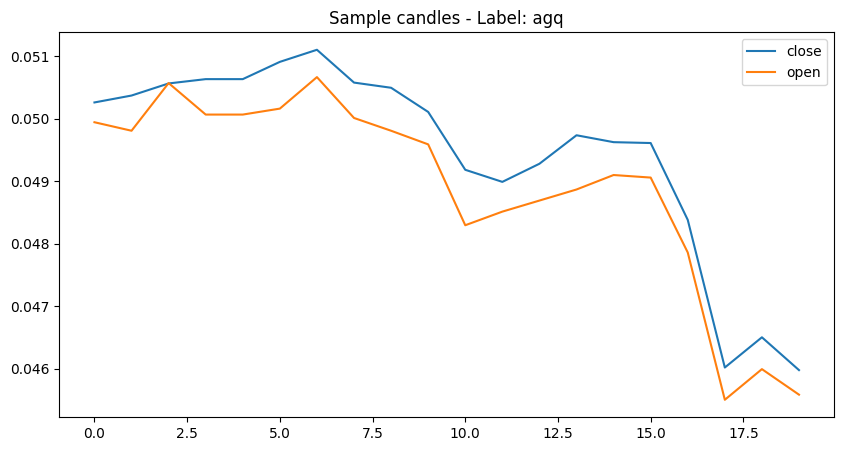

In [15]:
sample = x_train[10]
plt.figure(figsize=(10, 5))
plt.plot(sample[:,3], label="close")
plt.plot(sample[:, 0], label="open")
plt.title(f"Sample candles - Label: {classes[int(y_train[0])]}")
plt.legend()
plt.show()

# 4. Build CNN + LSTM model

In [ ]:
input_shape = x_train.shape[1:]
num_classes = len(classes)

inputs = layers.Input(shape=input_shape)

# Enhanced CNN with residual connection
x = layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

# Additional CNN layer
x = layers.Conv1D(filters=256, kernel_size=3, padding="causal", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

# Bidirectional LSTM for better pattern recognition
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dropout(0.4)(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dropout(0.4)(x)

# Dense layers with batch norm
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly higher LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# 5. Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(patience=4, factor=0.5, monitor='val_accuracy', verbose=1, min_lr=1e-6)
]

history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs=100,
    batch_size=64,  # Smaller batch size for better convergence
    callbacks = callbacks,
    verbose=1
)

# 6. Test the model

In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print((f"Test Accuracy : {test_accuracy}"))
# model.save("../models/candlestick_cnn_lstm.h5")

403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7969 - loss: 0.5967
Test Accuracy : 0.7968761920928955


# 7. Plot the Training History

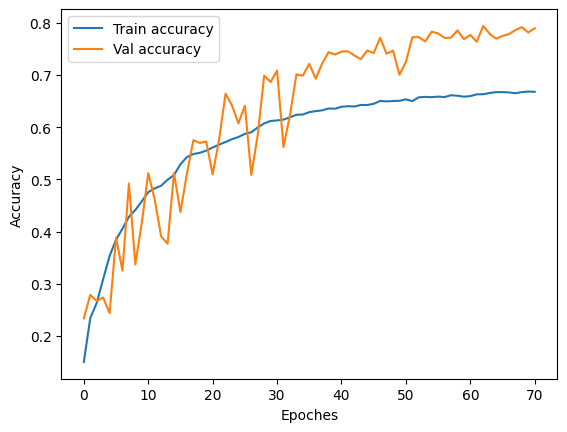

In [9]:
plt.plot(history.history['accuracy'], label= 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()